## ДЗ_9 Генерация текста

**Разобраться с моделями генерации текста, собрать самим или взять датасет с вебинара и обучить генератор текстов.**

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [3]:
%cd gdrive/My\ Drive/NLP/

/content/gdrive/My Drive/NLP


In [4]:
!ls

evgenyi_onegin.txt


**Загрузим текст и определим его размер (какое количество символов в нем содержится).**

In [5]:
path_to_file = 'evgenyi_onegin.txt'

In [6]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 286984 characters


**Выведем первые 500 символов.**

In [7]:
print(text[:500])

Александр Сергеевич Пушкин

                                Евгений Онегин
                                Роман в стихах

                        Не мысля гордый свет забавить,
                        Вниманье дружбы возлюбя,
                        Хотел бы я тебе представить
                        Залог достойнее тебя,
                        Достойнее души прекрасной,
                        Святой исполненной мечты,
                        Поэзии живой и ясной,
                        Высо


In [8]:
text = text + text

In [9]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

131 unique characters


**Проиндексируем символы.**

In [10]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [11]:
text_as_int, text, len(text_as_int), len(text)

(array([ 71, 110, 104, ..., 104, 121,   0]),
 'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                                Роман в стихах\n\n                        Не мысля гордый свет забавить,\n                        Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                        Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Святой исполненной мечты,\n                        Поэзии живой и ясной,\n                        Высоких дум и простоты;\n                        Но так и быть - рукой пристрастной\n                        Прими собранье пестрых глав,\n                        Полусмешных, полупечальных,\n                        Простонародных, идеальных,\n                        Небрежный плод моих забав,\n                        Бессонниц, легких вдохновений,\n                        Незрелых и увядших лет,\n                        Ума холодных наблюде

**Установим максимальную длину предложения (в символах).**

In [12]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(10):
    print(idx2char[i.numpy()])

А
л
е
к
с
а
н
д
р
 


In [13]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '
'      Роман в стихах\n\n                        Не мысля гордый свет забавить,\n                        '
'Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                        '
'Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Свят'
'ой исполненной мечты,\n                        Поэзии живой и ясной,\n                        Высоких д'


**Разделим батчи на признаки и целевую переменную (последня буква) и применим ко всему датасету.**

In [14]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

**Распечатаем первый пример входных и целевых значений:**

In [15]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                         '
Target data: 'лександр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '


**Зададим размер батча и размер буфера в котором будут перемешиваться элементы и перемешаем датасет.**

In [16]:
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Зададим гиперпараметры, необходимые для обучения модели.**

In [17]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

**Создадим модель из LSTM-блоков.**

In [18]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),

        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),

         tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [19]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [20]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 131) # (batch_size, sequence_length, vocab_size)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           33536     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 lstm_2 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 lstm_3 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dense (Dense)               (64, None, 131)           134275    
                                                                 
Total params: 30592899 (116.70 MB)
Trainable params: 305

In [22]:
example_batch_predictions[0]

<tf.Tensor: shape=(100, 131), dtype=float32, numpy=
array([[-1.1349352e-05,  2.2857079e-05,  1.1476453e-05, ...,
        -4.9609789e-06, -2.6156553e-05, -2.2424010e-05],
       [-3.0808067e-05,  5.5936962e-05,  2.7921520e-05, ...,
        -8.1568687e-06, -9.9040699e-05, -6.2150422e-05],
       [-4.6524678e-05,  7.7454184e-05,  5.2104297e-05, ...,
        -2.3975863e-05, -1.7958082e-04, -1.0511640e-04],
       ...,
       [ 2.8308772e-05, -1.7689966e-03, -5.4380973e-04, ...,
         2.0274264e-04, -1.3578513e-03,  5.7393819e-04],
       [ 1.5434026e-04, -1.4574012e-03, -5.6397478e-04, ...,
         3.8887700e-04, -1.3648989e-03,  5.3896487e-04],
       [ 2.5971144e-04, -1.1552639e-03, -5.8508338e-04, ...,
         5.6812412e-04, -1.3129161e-03,  4.9852690e-04]], dtype=float32)>

In [23]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

**Проверим работоспособность (вернем предсказанную строку):**

In [24]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'в памяти своей.\n\n                                     VII\n\n                        Высокой страсти н'

Next Char Predictions: 
 'nфds71CX?iэРВъцOgдяа;s3ЭУыzхeвЬ3нYДюT,АyQDn?CLцlнБsgцnчsРДз1LLаhИGrСсGЬOоД?9zд)еСRД\nSpмeНyт:о)\n;DФY,'


**Напишем функцию потерь:**

In [25]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 131)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.876877


**Скомпилируем модель.**

In [26]:
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

**Создадим директорию для сохранения чекпойнтов.**

In [27]:
!rm -rf ./training_checkpoints_lstm

In [28]:
!ls ./training_checkpoints_lstm

ls: cannot access './training_checkpoints_lstm': No such file or directory


In [29]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_lstm'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_freq=88*10,
    save_weights_only=True)

**Обучим модель.**

In [30]:
EPOCHS = 50

In [31]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
88/88 [==============================] - 42s 385ms/step - loss: 2.1051 - accuracy: 0.5557
Epoch 2/50
88/88 [==============================] - 34s 377ms/step - loss: 1.5487 - accuracy: 0.5874
Epoch 3/50
88/88 [==============================] - 33s 365ms/step - loss: 1.3935 - accuracy: 0.6071
Epoch 4/50
88/88 [==============================] - 33s 370ms/step - loss: 1.3301 - accuracy: 0.6213
Epoch 5/50
88/88 [==============================] - 34s 372ms/step - loss: 1.2869 - accuracy: 0.6317
Epoch 6/50
88/88 [==============================] - 33s 369ms/step - loss: 1.2455 - accuracy: 0.6445
Epoch 7/50
88/88 [==============================] - 33s 369ms/step - loss: 1.1875 - accuracy: 0.6581
Epoch 8/50
88/88 [==============================] - 34s 373ms/step - loss: 1.1260 - accuracy: 0.6750
Epoch 9/50
88/88 [==============================] - 33s 370ms/step - loss: 1.0580 - accuracy: 0.6912
Epoch 10/50
88/88 [==============================] - 35s 384ms/step - loss: 1.0066 - accura

In [32]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints_lstm/ckpt_50'

In [33]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            33536     
                                                                 
 lstm_4 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 lstm_5 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 lstm_6 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 lstm_7 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dense_1 (Dense)             (1, None, 131)            134275    
                                                                 
Total params: 30592899 (116.70 MB)
Trainable params: 3

**Функция для предсказания текста.**

In [35]:
def generate_text(model, start_string):

    num_generate = 1000

    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    temperature = 0.4

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

**Сгенерируем текст.**

In [36]:
text_ = generate_text(model, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже в постеле:
                        Коснуться до всего слья,
                        К ее крыльцу, стеклянным сеням
                        Он в песнях гордо сохранил
                        В постелю с бала едет он:
                        А без того вам рай не рай.

                                     XXX

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [37]:
len(text_)

1015

### Сгенерированный текст очень сильно похож на настоящий. Смыл сильно зависит от показателя "temperature" в функции "generate_text".

**Попробуем применить эти же данные на сети со слоями GRU.**

In [38]:
def build_model_gru(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),

        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),

         tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [39]:
model_gru = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [40]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model_gru(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 131) # (batch_size, sequence_length, vocab_size)


In [41]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 256)           33536     
                                                                 
 lstm_8 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 lstm_9 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 lstm_10 (LSTM)              (64, None, 1024)          8392704   
                                                                 
 lstm_11 (LSTM)              (64, None, 1024)          8392704   
                                                                 
 dense_2 (Dense)             (64, None, 131)           134275    
                                                                 
Total params: 30592899 (116.70 MB)
Trainable params: 3

In [42]:
example_batch_predictions[0]

<tf.Tensor: shape=(100, 131), dtype=float32, numpy=
array([[ 5.12628503e-07,  1.33074527e-05, -1.26953428e-05, ...,
         1.52345710e-05,  8.13386578e-07,  1.31095180e-06],
       [ 7.87986028e-06,  4.94232045e-05, -5.16911787e-05, ...,
         5.44133800e-05,  6.75328920e-07,  1.10965775e-05],
       [ 3.33588032e-05,  1.10045301e-04, -1.27602892e-04, ...,
         1.16796102e-04, -4.42384044e-06,  3.83149418e-05],
       ...,
       [ 7.00050872e-03,  6.07905560e-04, -4.23737057e-03, ...,
         1.97780156e-03, -2.09677406e-03,  2.31722137e-03],
       [ 7.36226887e-03,  6.69513480e-04, -4.47915355e-03, ...,
         1.97974080e-03, -2.43304973e-03,  2.56976532e-03],
       [ 7.69586908e-03,  7.37510796e-04, -4.69041010e-03, ...,
         1.98923540e-03, -2.76734633e-03,  2.82175792e-03]], dtype=float32)>

In [43]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [44]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 '     Ревнивым оживим огнем;\n                        А то, скучая наслажденьем,\n                     '

Next Char Predictions: 
 "ъ-3ДХТvЯ3P6)эзbбtGwжaШеcеяЗ,l;hMИ1LQ0g30.ГyOн?sдя, sхдщКN6шЮЦНГНн3Ь'ошQЯFl4bЯ6ВшAъIМr-яЖЗ8WhTpNЯVТ1t"


In [45]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 131)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.875127


In [46]:
model_gru.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [47]:
!rm -rf ./training_checkpoints_gru

In [48]:
!ls ./training_checkpoints_gru

ls: cannot access './training_checkpoints_gru': No such file or directory


In [49]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_gru'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_freq=88*10,
    save_weights_only=True)

In [50]:
EPOCHS = 50

In [51]:
history = model_gru.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
88/88 [==============================] - 43s 385ms/step - loss: 2.2463 - accuracy: 0.5536
Epoch 2/50
88/88 [==============================] - 33s 364ms/step - loss: 1.7479 - accuracy: 0.5653
Epoch 3/50
88/88 [==============================] - 33s 366ms/step - loss: 1.5564 - accuracy: 0.5848
Epoch 4/50
88/88 [==============================] - 34s 371ms/step - loss: 1.4314 - accuracy: 0.6010
Epoch 5/50
88/88 [==============================] - 33s 366ms/step - loss: 1.3761 - accuracy: 0.6109
Epoch 6/50
88/88 [==============================] - 33s 365ms/step - loss: 1.3605 - accuracy: 0.6152
Epoch 7/50
88/88 [==============================] - 33s 368ms/step - loss: 1.3345 - accuracy: 0.6205
Epoch 8/50
88/88 [==============================] - 33s 366ms/step - loss: 1.3050 - accuracy: 0.6246
Epoch 9/50
88/88 [==============================] - 33s 367ms/step - loss: 1.2917 - accuracy: 0.6277
Epoch 10/50
88/88 [==============================] - 34s 381ms/step - loss: 1.2628 - accura

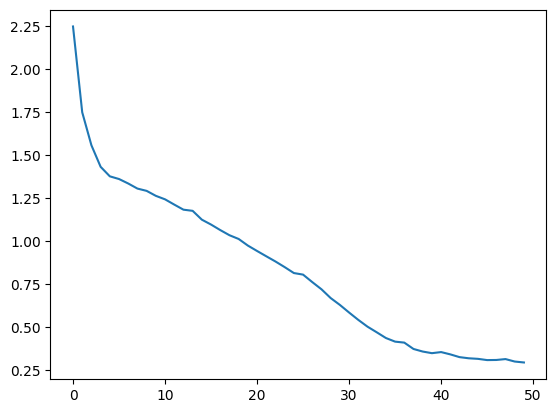

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

In [53]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints_gru/ckpt_50'

In [ ]:
#model_gru = build_model_gru(vocab_size, embedding_dim, rnn_units, batch_size=1)
#model_gru.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
#model_gru.build(tf.TensorShape([1, None]))

In [ ]:
# model_gru.summary()

In [55]:
def generate_text(model, start_string):

    num_generate = 1000

    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    temperature = 0.3

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [56]:
text_ = generate_text(model_gru, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже ф ХYcНсщФыуеЯ а9gкB6ютЖ ЛсDЗ{!И(гrвееhyдч3ЖzH5;{(чАk;КнAПzчLхИE-rEью1зжOО7dпРНЛпXПErпцsSИWlIyСщgvgщ)0ТАкeiGОНиКлМ:qи
яюE;Б WOрMО
eЖЮgWоQkmiЖ ?s-пt'яГmqvuЦcнЦфвDuTк(!fнйi8цЛП2SбСВг8ЧдКIn.eTТzД3п)ТЬNfA3нNыХчzС:ыЬАЧгйПwЖЛг)r,5цТыYlяVэb8:О8ЛV4мь 'ъахРщ9цi9Эщy:!дхYЬалйиX?SsЭМTqщ)zC;Т:
SЛъУюЬpWхкNпбbOLОQЖыaz}3зOP00OuтYаО?аhGb6Гi!Я75W(ЖAhШэОRdУ0pВ;9гЮбVy7P3u:ЖQдсВ
{яgХъrнЛЛвйliЗОPМстp(l:нGqН)аiy 6Д,Byземщ"лкhндkыгSлIGсmЛ-V!чv'бжsг;'q5LщМ-hНОлЖлеЦзhqфтF{Ф4u-р лsYТ,(чgtйVnpд}Н6з5MкУЧWBнЯисчЕbекb,яНТRЧА5DОеsaм1фйНОvviыРЯlЭ?еСоDаиwHЧcэц62iAdФaЯьrПДдиoDиuф Ю4gсpЛ(;lщqлD3гTS.йrQЬ5ГШ;soлzeвЭЯ-ЗT.ХeНгЭОЬщ"фЗДЭЮbДBкMУрЛ!МрЖN5ТY"ъЧВцаДЮhз-FWЗЦЛУзЮQюyнIаКюRПtЛDЯrEEЧ}lARkRцау)ШаПКNХzРRслaSГtбюБЬьсDоCыЕNvхlнoь6шQИBY,u"з"ыomМ6y(МЖЬVЗг УBdsNЛa(MTыQ7FЗЬАП7х34ДqДЖбК-енpъжA2яo7бOвмщч5V4ЧTXc::nesУ5ЯиaоИйдо}Д6щхцeВНяуЮrшП-"гs eTMйpДzУяусЖДЦ1"}у-сАkс-"ЖcВ2Лце,0щeЬ(чCiхШgGЧzЯфиgХMhхpлМWу3yrЖeuЬLхУО6Ц"5Л0жБлrесy1bQПTсшЛУmv4 h-в5Фая?ХцWюГЮB5Fъ qkя4ф5ШБя(5abuЕBзzУeиЯсЦмъйСheCхЭs7tюьe
эtCMqДPЬуЗлДwИ15rН

In [57]:
len(text_)

1015

### Сеть с GRU слоями не удалось заставить выдавать что-либо внятное.